In [106]:
import numpy as np
from utils import *
from keras import callbacks
import tensorflow as tf
import time
from tqdm import tqdm

In [91]:
IMG_SIZE=32

# Set the path to the folder containing the image data
data_path = '../dataset/input_resized_256/flowers/'

# Create an instance of the DimReductionEvaluation class
dre = DimReductionEvaluation()
dre.load_data(data_path, IMG_SIZE)

Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_521 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_224 (MaxPooli  (None, 16, 16, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_529 (Ba  (None, 16, 16, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_522 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_225 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                                           
                                                    

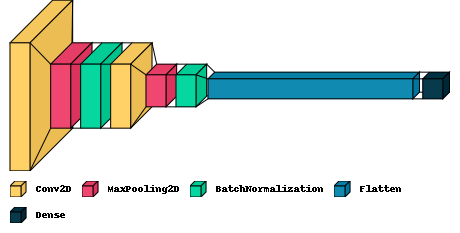

In [96]:
batch_size=32
dae_cnn=DAE_CNN(batch_size=batch_size,
                 input_shape=(IMG_SIZE, IMG_SIZE, 3),latent_dim=100)

dae=DAE(batch_size=batch_size,
                 input_dim=IMG_SIZE*IMG_SIZE*3, latent_dim=100)

dae_cnn.encoder.summary()
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(dae_cnn.encoder, legend=True)


Model: "model_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_86 (InputLayer)       [(None, 3072)]            0         
                                                                 
 dense_210 (Dense)           (None, 1536)              4720128   
                                                                 
 batch_normalization_503 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 activation_42 (Activation)  (None, 1536)              0         
                                                                 
 dense_211 (Dense)           (None, 768)               1180416   
                                                                 
 batch_normalization_504 (Ba  (None, 768)              3072      
 tchNormalization)                                        

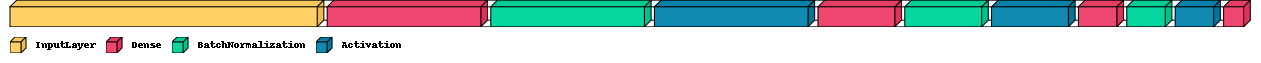

In [84]:
dae.encoder.summary()
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(dae.encoder, legend=True)


In [85]:
x_train, x_test, y_train, y_test = dre.split_data(dre.X, dre.Y, test_size=0.1)
x_train_flat=x_train.reshape(x_train.shape[0], -1)
x_test_flat=x_test.reshape(x_test.shape[0], -1)
x_train_flat.shape

(3885, 3072)

In [100]:
History=dae.fit(x_train_flat, y_train, epochs=100, verbose=1)
# History=dae.autoencoder.fit(
#             x_train_flat,
#             x_train_flat,
#             epochs=100,
#             batch_size=dae.batch_size,
#             validation_data=(x_test_flat, x_test_flat),
#             verbose=1,
#             callbacks=[
#                 callbacks.EarlyStopping(
#                     monitor='val_loss',
#                     min_delta=0.01,
#                     patience=10,
#                     restore_best_weights=True)]
#             )

Epoch 1/100
122/122 [==============================] - 4s 32ms/step - loss: 0.2921 - val_loss: 0.2893
Epoch 2/100
122/122 [==============================] - 3s 27ms/step - loss: 0.2919 - val_loss: 0.2879
Epoch 3/100
122/122 [==============================] - 3s 25ms/step - loss: 0.2918 - val_loss: 0.2880
Epoch 4/100
122/122 [==============================] - 3s 25ms/step - loss: 0.2912 - val_loss: 0.2883
Epoch 5/100
122/122 [==============================] - 3s 23ms/step - loss: 0.2913 - val_loss: 0.2866
Epoch 6/100
122/122 [==============================] - 3s 24ms/step - loss: 0.2905 - val_loss: 0.2871
Epoch 7/100
122/122 [==============================] - 3s 25ms/step - loss: 0.2904 - val_loss: 0.2863
Epoch 8/100
122/122 [==============================] - 3s 23ms/step - loss: 0.2902 - val_loss: 0.2874
Epoch 9/100
122/122 [==============================] - 3s 24ms/step - loss: 0.2898 - val_loss: 0.2856
Epoch 10/100
122/122 [==============================] - 3s 23ms/step - loss: 0.289

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Range of K values to test
k_range=(np.linspace(0.001, 0.1, 3)*dre.dim).astype(np.int64)
batch_size=32

# Test the performance of the different dimensionality reduction methods
accuracy_DAE_CNN=[]
accuracy_DAE=[]
time_DAE_CNN=[]

x_train, x_test, y_train, y_test = dre.split_data(dre.X, dre.Y, test_size=0.1)
x_train_flat=x_train.reshape(x_train.shape[0], -1)
x_test_flat=x_test.reshape(x_test.shape[0], -1)

# Create a KNN classifier
params = {
        "n_neighbors":
        [i for i in range(1, int(np.sqrt(3)*IMG_SIZE))]
}

random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=params,
    n_iter=60,
    cv=5,
    n_jobs=-1)
histories=[]

# Make 5 runs
for i in range(1):

    accuracy_DAE_CNN_=[]
    time_DAE_CNN_=[]
    accuracy_DAE_=[]
    time_DAE_=[]

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = dre.split_data(dre.X, dre.Y, test_size=0.1)
    x_train_flat=x_train.reshape(x_train.shape[0], -1)
    x_test_flat=x_test.reshape(x_test.shape[0], -1) 

    # Fit the k-NN classifier to the training data
    # random_search.fit(x_train_flat, y_train)
    # baseline=random_search.score(x_test_flat, y_test)
    # print('Baseline accuracy: ', baseline)

    # Test the performance for different k values
    for k in tqdm(k_range):
        
        # Create an instance of the DAE class
        s_time=time.time()
        dae_cnn=DAE_CNN(latent_dim=k, batch_size=batch_size,
                         input_shape=(IMG_SIZE, IMG_SIZE, 3))

        dae=DAE(latent_dim=k, batch_size=batch_size,
                    input_dim=IMG_SIZE*IMG_SIZE*3)
        
        # Fit the DAE to the training data
        History=dae_cnn.fit(x_train, y_train, epochs=150, verbose=1)
        histories.append(History)
        dae.fit(x_train_flat, y_train, epochs=150, verbose=1)

        # Evaluate the performance of the DAE
        time_DAE_CNN_.append(time.time()-s_time)
        random_search.fit(dae_cnn.transform(x_train), y_train)
        accuracy_DAE_CNN_.append(random_search.score(dae_cnn.transform(x_test), y_test))
        print('Accuracy: ', accuracy_DAE_CNN_[-1]
              , 'Time: ', time_DAE_CNN_[-1])
        
        random_search.fit(dae.transform(x_train_flat), y_train)
        accuracy_DAE_.append(random_search.score(dae.transform(x_test_flat), y_test))
        print('Accuracy: ', accuracy_DAE_[-1])

    accuracy_DAE_CNN.append(accuracy_DAE_CNN_)
    accuracy_DAE.append(accuracy_DAE_)
    time_DAE_CNN.append(time_DAE_CNN_)

accuracy_DAE_CNN=np.array(accuracy_DAE_CNN).transpose()
accuracy_DAE=np.array(accuracy_DAE).transpose()

time_DAE_CNN=np.array(time_DAE_CNN).transpose()


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/150
122/122 [==============================] - 7s 45ms/step - loss: 0.4870 - val_loss: 0.3487
Epoch 2/150
122/122 [==============================] - 2s 20ms/step - loss: 0.3415 - val_loss: 0.3215
Epoch 3/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3341 - val_loss: 0.3083
Epoch 4/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3212 - val_loss: 0.3029
Epoch 5/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3179 - val_loss: 0.2991
Epoch 6/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3167 - val_loss: 0.3042
Epoch 7/150
122/122 [==============================] - 2s 18ms/step - loss: 0.3161 - val_loss: 0.2985
Epoch 8/150
122/122 [==============================] - 2s 18ms/step - loss: 0.3145 - val_loss: 0.2979
Epoch 9/150
122/122 [==============================] - 2s 18ms/step - loss: 0.3134 - val_loss: 0.2963
Epoch 10/150
122/122 [==============================] - 2s 18ms/step - loss: 0.312

/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 8ms/step
Accuracy:  0.3287037037037037 Time:  105.94603490829468
122/122 [==============================] - 1s 4ms/step


/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 15ms/step


 33%|███▎      | 1/3 [01:48<03:37, 108.84s/it]

Accuracy:  0.3449074074074074
Epoch 1/150
122/122 [==============================] - 7s 45ms/step - loss: 0.4540 - val_loss: 0.3362
Epoch 2/150
122/122 [==============================] - 3s 21ms/step - loss: 0.3121 - val_loss: 0.3256
Epoch 3/150
122/122 [==============================] - 2s 20ms/step - loss: 0.3004 - val_loss: 0.3095
Epoch 4/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2915 - val_loss: 0.2944
Epoch 5/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2861 - val_loss: 0.2887
Epoch 6/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2864 - val_loss: 0.2864
Epoch 7/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2815 - val_loss: 0.2850
Epoch 8/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2809 - val_loss: 0.2829
Epoch 9/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2795 - val_loss: 0.2822
Epoch 10/150
122/122 [==============================

/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 11ms/step
Accuracy:  0.4537037037037037 Time:  119.1641321182251
122/122 [==============================] - 1s 4ms/step


/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 15ms/step


 67%|██████▋   | 2/3 [03:52<01:57, 117.62s/it]

Accuracy:  0.42592592592592593
Epoch 1/150
122/122 [==============================] - 7s 45ms/step - loss: 0.4514 - val_loss: 0.3379
Epoch 2/150
122/122 [==============================] - 3s 21ms/step - loss: 0.3144 - val_loss: 0.3392
Epoch 3/150
122/122 [==============================] - 2s 20ms/step - loss: 0.2981 - val_loss: 0.3251
Epoch 4/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2915 - val_loss: 0.3058
Epoch 5/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2894 - val_loss: 0.2958
Epoch 6/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2834 - val_loss: 0.2938
Epoch 7/150
122/122 [==============================] - 2s 18ms/step - loss: 0.2818 - val_loss: 0.2911
Epoch 8/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2807 - val_loss: 0.2874
Epoch 9/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2794 - val_loss: 0.2864
Epoch 10/150
122/122 [=============================

/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 14ms/step
Accuracy:  0.3958333333333333 Time:  114.54768991470337
122/122 [==============================] - 1s 4ms/step


/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 19ms/step


100%|██████████| 3/3 [05:53<00:00, 117.69s/it]

Accuracy:  0.4537037037037037


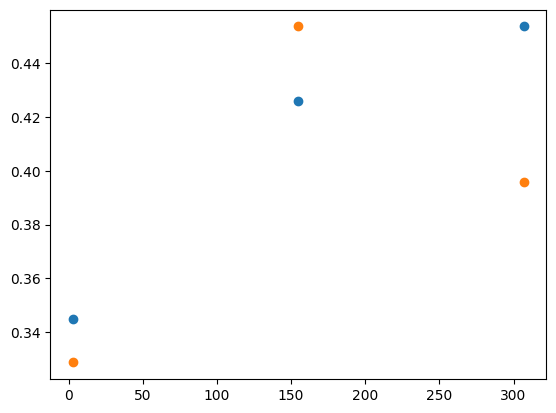

In [105]:
import matplotlib.pyplot as plt
plt.plot(k_range, accuracy_DAE, 'o')
plt.plot(k_range, accuracy_DAE_CNN, 'o')

In [ ]:
model1=tf.keras.models.load_model('../models/CNN_model_1.h5')

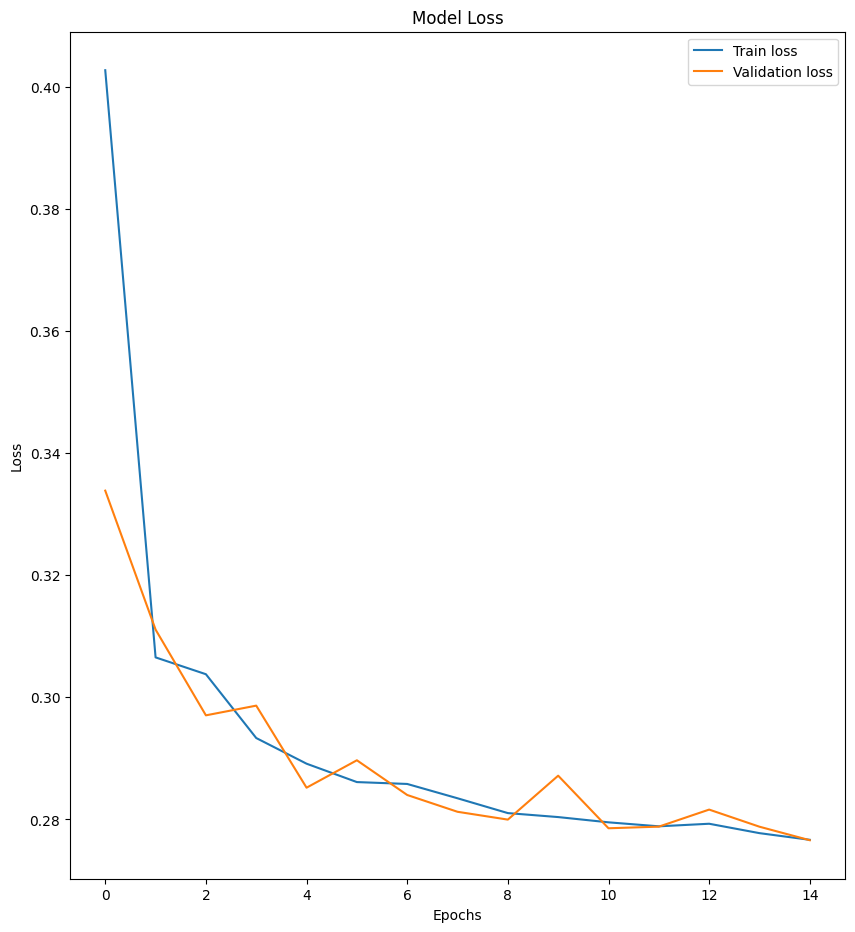

In [232]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,11))

plt.plot(History.history['loss'], label='Train loss')
plt.plot(History.history['val_loss'], label='Validation loss')

plt.legend()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [107]:
k_range=(np.linspace(0.001, 0.1, 3)*dre.dim).astype(np.int64)
re=ReductionAnalysis(dre.X, dre.Y, k_range, batch_size=32)
re.evaluate_k('PCA', k=10)

UnboundLocalError: local variable 'score' referenced before assignment